# Installation


In [ ]:
%pip install -r requirements.txt
%pip install -U huggingface_hub[cli]

In [1]:
print("All required packages have been installed and updated successfully.")

All required packages have been installed and updated successfully.


In [ ]:
!conda install -c conda-forge poppler -y

# Imports

In [1]:
import os
from os.path import join
import random
from tqdm import tqdm
from glob import glob
from pdf2image import convert_from_path
from PIL import Image , ImageEnhance
from dotenv import load_dotenv
from huggingface_hub import login

c:\Users\a1hmm\miniconda3\envs\torchENV\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv()
api_key = os.getenv("Hugging_Face_Token")
login(api_key)

In [3]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

: 

# Paths

In [3]:
data_dir = os.path.join(os.getcwd(), "Data")
os.makedirs(data_dir, exist_ok=True)

pdfs_dir = os.path.join(data_dir, "pdfs")
os.makedirs(pdfs_dir, exist_ok=True)

output_dir = os.path.join(data_dir, "pdf_images")
os.makedirs(output_dir, exist_ok=True)

# Pdf to images

In [4]:
def preprocess_image(image , max_width = 600):
    gray_image = image.convert('L')
    if gray_image.width > max_width:
        ratio = max_width / gray_image.width
        new_height = int(gray_image.height * ratio)
        gray_image = gray_image.resize((max_width, new_height), Image.LANCZOS)
    
    enhancer = ImageEnhance.Contrast(gray_image)
    enhanced_image = enhancer.enhance(1.5)

    return enhanced_image


def convert_pdf_to_images(pdf_path, output_dir , max_width = 600):
    pdf_name = os.path.basename(pdf_path).split('.')[0]
    output_dire = join(output_dir , pdf_name)
    os.makedirs(output_dire, exist_ok=True)
    print(f"Processing {pdf_name}...")
    images = convert_from_path(pdf_path, dpi=200,
                               poppler_path=r"C:\Users\a1hmm\miniconda3\envs\torchENV\Library\bin")
    generated_pathes = []
    for i, image in enumerate(images , start=1):

        preprocessed_image = preprocess_image(image , max_width)
        image_path = join(output_dire, f"page_{i:03d}.jpg")
        preprocessed_image.save(image_path, format='JPEG', quality=85)
        print(f"Saved {image_path}")
        generated_pathes.append(image_path)

    return generated_pathes

In [ ]:
pdf_files = glob(join(pdfs_dir, "*.pdf"))
max_width = 600


for pdf_file in tqdm(pdf_files):
    convert_pdf_to_images(pdf_file, output_dir , max_width)

# Evaluate Base Model

In [5]:
from transformers import AutoProcessor, Gemma3ForConditionalGeneration
from IPython.display import Image as IPImage ,display
from PIL import Image
import torch

model_id = "google/gemma-3-4b-it"

sample_image_path = "Data/pdf_images/law_1/page_006.jpg"

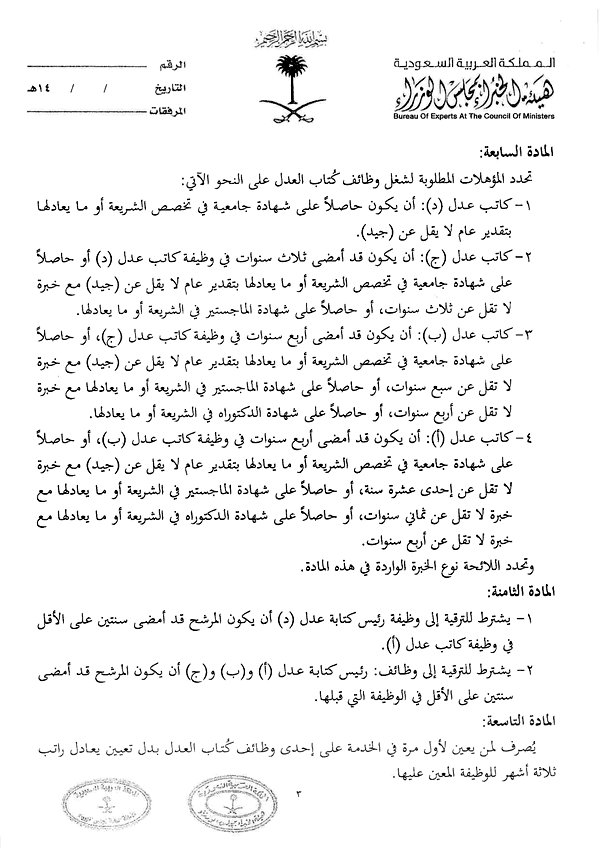

In [6]:
display(IPImage(sample_image_path))

In [7]:
torch.backends.cuda.matmul.allow_tf32 = True

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using:", device)


model = Gemma3ForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    device_map="auto",          # يوزع GPU/CPU
    low_cpu_mem_usage=True
).eval()

processor = AutoProcessor.from_pretrained(model_id)

Using: cuda


c:\Users\a1hmm\miniconda3\envs\torchENV\Lib\site-packages\huggingface_hub\file_download.py:130: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\a1hmm\.cache\huggingface\hub\models--google--gemma-3-4b-it. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Loading weights: 100%|██████████| 883/883 [00:14<00:00, 60.87it/s, Materializing param=model.vision_tower.vi

In [8]:
prompt = """
Act as an OCR model. Extract the exact details of the image into a markdown format.

## Output:
```markdown
""".strip()

message = [
    {
        "role": "system",
        "content":[{"type": "text", "text": "You are a helpful  assistant."}]
    },
    {
        "role": "user",
        "content": [
            {"type": "image", "image": sample_image_path},
            {"type": "text", "text": prompt},
            
        ]
    }
]

inputs = processor.apply_chat_template(
    message,
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors="pt"
).to(model.device)

input_len = inputs["input_ids"].shape[-1]

with torch.inference_mode():
    generation = model.generate(**inputs, max_new_tokens=1024,do_sample=False)
    generation = generation[0][input_len:]

decode = processor.decode(generation, skip_special_tokens=True)
print(decode)


The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


ValueError: Using `or_mask_function` or `and_mask_function` arguments require torch>=2.6